# Utility Section

Imports

In [1]:
# Import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Iterable, Tuple

Utils class

In [2]:
# Utility class for HW_3
class Utils():
    
    __X = None
    __Y = None
    __H = None
    
    def sigmoid(z: np.ndarray) -> Iterable[float]:
        if z is None:
            return None
        return 1/(1 + np.exp(-z))
    
    def cost_function(weights: np.ndarray, 
                      dataset:pd.DataFrame, 
                      use_regularization:bool=True) -> Tuple[float, np.ndarray]:
        """
        Method to calculate Cost Function and new weights for a logistic regression 
        model with Gradient-Descent [GD] algorithm.

        Args:
            weights [type: np.array]: initial weights value.
            dataset [type: pd.DataFrame]: data set for linear regression.
            use_regularization [type: bool]: decide if x values will be regularized.
                                             default value --> False.

        Raises:
            1. Exception: Failed to calculate hypothesis for input file.

        Returns:
            cost, weights [type: Tuple[float, np.ndarray]]: cost value and new weights
                                                            for a single GD step.
        """
        x = Utils.get_x_vals(dataset, use_regularization)
        y = Utils.get_y_vals(dataset, x, use_regularization) 
        h = Utils.__get_h_vals(weights)
        m = y.shape[0]
        cost = -(1/m) * np.sum(y*np.log(h) + (1-y)*np.log(1-h))
        gradient = Utils.__gradient(h, x, y)
        return float(cost), gradient

    def get_init_weights(dataset: pd.DataFrame) -> np.array:
        num_of_featues = (dataset.shape[1])
        weights = np.random.rand(num_of_featues, 1)
        weights[0] = 1
        weights = np.array(weights)
        return weights

    def reset_variables() -> None:
        Utils.__X = None
        Utils.__Y = None

    def check_convergence(last_cost: float, new_cost: float, epsilon: float) -> bool:
        ascending = new_cost > last_cost
        ascending_err_msg = f'Cost function ascending detected!\n' +\
                            f'New cost: {new_cost}, Last cost: {last_cost}'
        if ascending: raise Exception(ascending_err_msg)
        step_change = np.abs(last_cost-new_cost)
        is_converge = step_change < epsilon
        return is_converge

    def get_x_vals(dataset: pd.DataFrame, use_regularization: bool) -> np.ndarray:
        if Utils.__X is None:
            x = dataset.iloc[:,:-1]
            if use_regularization:
                x_min = np.min(x)
                x_max = np.max(x)
                x_mean = np.mean(x)
                x = (x-x_mean)/(x_max-x_min)
            ones = np.ones((x.shape[0], 1)) 
            x = np.concatenate((ones, x), axis=1)
            Utils.__X = x
        return Utils.__X

    def get_y_vals(dataset: pd.DataFrame, x: np.ndarray, use_regularization: bool) -> np.ndarray:
        if Utils.__Y is None:
            y = np.array(dataset.iloc[:,-1])
            y = y.reshape(x.shape[0], 1)
            if use_regularization:
                y_min = np.min(y)
                y_max = np.max(y)
                y_mean = np.mean(y)
                y = (y-y_mean)/(y_max-y_min)
            Utils.__Y = y
        return Utils.__Y

    def __gradient(h: np.ndarray, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        m = x.shape[0]
        return (1/m) * np.dot(np.transpose(x), h-y)

    def __get_h_vals(weights: np.ndarray=None) -> np.ndarray:
        if Utils.__X is None or Utils.__Y is None:
            return None
        if weights is None:
            raise Exception('Failed to calculate hypothesis for input file.')
        h = Utils.sigmoid(np.dot(Utils.__X, weights))
        if Utils.__H is None:
            Utils.__H = h
        return h

class LogisticRegressionModel():

    def __init__(self, 
                 dataset: pd.DataFrame,
                 use_regularization: bool=True,
                 max_iters: int=1000000,
                 epsilon: float=1e-7):
        self.dataset = dataset
        self.use_regularization = use_regularization
        self.max_iters = max_iters
        self.epsilon = epsilon
        self.__gd__weights = None
    
    def train_model(self, plot_cost_graph:bool) -> None:
        Utils.reset_variables()

        try:
            cost_values = []
            last_cost, weights = Utils.cost_function(
                weights=Utils.get_init_weights(dataset=self.dataset), 
                dataset=self.dataset)
            cost_values.append(last_cost)
            new_cost = 0.0
            iter = 0

            while not Utils.check_convergence(last_cost, new_cost, self.epsilon):
                if iter == self.max_iters: 
                    print(f'Failed to converge with max iters: {self.max_iters}')
                    break
                if iter > 0:
                    last_cost = new_cost
                new_cost, weights = Utils.cost_function(weights, self.dataset)
                cost_values.append(new_cost)
                iter+=1

            self.__gd__weights = weights
            if plot_cost_graph:
                plt.plot(range(0, iter+1), cost_values)
                plt.xlabel('Iterations', size=12)
                plt.ylabel('J(Θ)', size=12)
                plt.title(f'J(Θ) over number of iterations graph', size=18, fontweight="bold")
        
        except Exception as e:
            print(e)

    def get_gd_weights(self) -> np.ndarray: 
        return self.__gd__weights

    def scatter_plot_dataset(self) -> None:
        ax = sns.scatterplot(data=self.dataset, 
                            x='Score1', 
                            y='Score2', 
                            hue='Binary tagging',
                            palette=['red', 'green'])
        legend_handles, _ = ax.get_legend_handles_labels()
        plt.title('Test Scores To Pass/Fail Course Scatter', size=18,  fontweight='bold')
        plt.legend(legend_handles, ['Failed', 'Passed'])

    def plot_decision_boundary_2D(self, resolution: int = 10000) -> None:
        x = Utils.get_x_vals(self.dataset, use_regularization=False)
        if x is not None:
            theta0 = self.__gd__weights[0]
            theta1 = self.__gd__weights[1]
            theta2 = self.__gd__weights[2]
            x1 = np.linspace(np.min(x), np.max(x), resolution)
            x2 = -1*(theta0 + theta1*x1)
            plt.plot(x1, x2, color='blue', label='decition boundary')


CSV files loads

In [3]:
base_path = os.path.abspath(os.curdir)

q1_data_path = f"{base_path}\\ex2data1.txt"
q1_df = pd.read_csv(q1_data_path, sep=',', header=None, names= ['Score1', 'Score2','Binary tagging'])
# print(q1_df)

q2_data_path = f"{base_path}\\ex2data2.txt"
q2_df = pd.read_csv(q2_data_path, sep=',', header=None)
# print(q2_df)

Scatter plot of first data file 

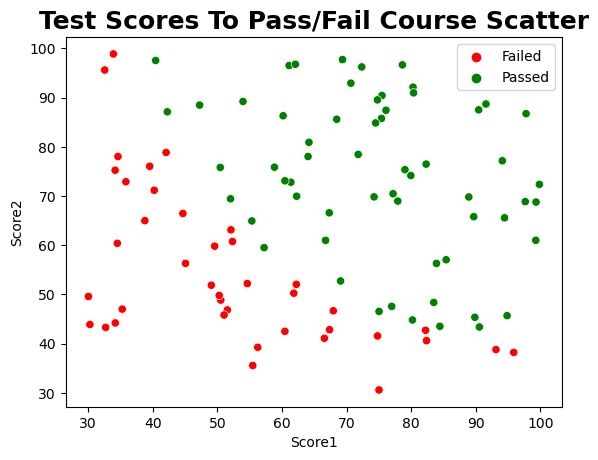

In [4]:
single_variable_model = LogisticRegressionModel(dataset=q1_df, epsilon=1e-6)
single_variable_model.scatter_plot_dataset()

Sigmoid graph example

Text(0.5, 1.0, 'Sigmoid Function')

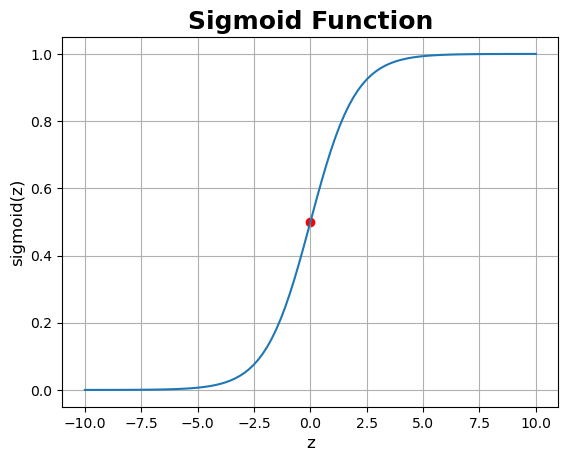

In [5]:
z = np.linspace(-10,10,100)
y = Utils.sigmoid(z)
plt.plot(z,y)
plt.grid()
plt.scatter(0, 0.5, color='red')
plt.xlabel('z', size=12)
plt.ylabel('sigmoid(z)', size=12)
plt.title('Sigmoid Function', size=18,  fontweight='bold')

Train Logistic Regression Model for data set #1

c:\Users\galsa\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\galsa\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\galsa\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


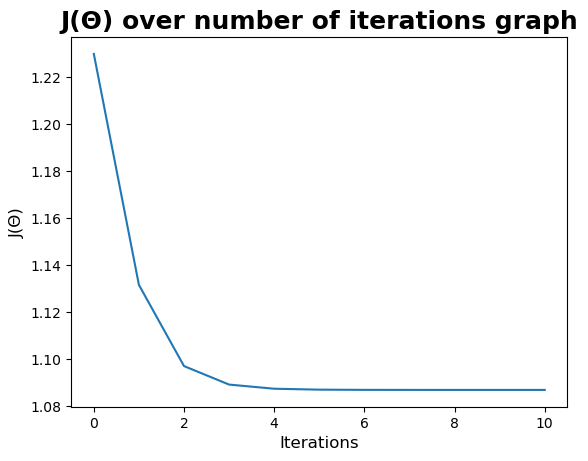

In [6]:
single_variable_model.train_model(plot_cost_graph=True)

Plot decition boundary

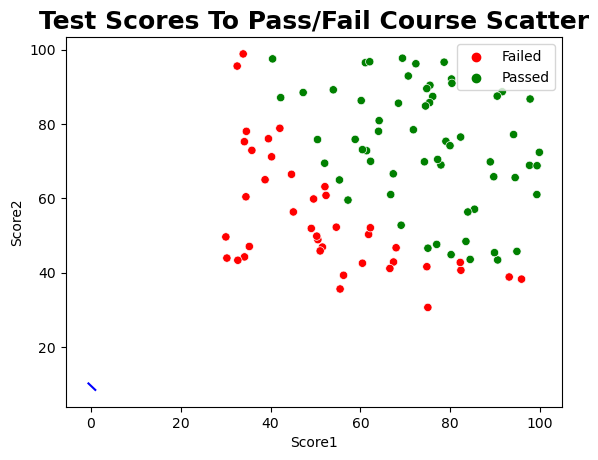

In [7]:
single_variable_model.scatter_plot_dataset()
single_variable_model.plot_decision_boundary_2D(resolution=10000)